In [155]:
import glia
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np, tables, torch, torchvision
from tqdm import tqdm
from glia.reconstructions.lib import resize_3d, gray_3d, ImageData, RetinaData, \
     ConcatDataset, ImageRetina
from glia.reconstructions.models.john_conv import ConvNet
import torch.nn.functional as F

In [2]:
model_checkpoint_path = "/data/uw/models/2020-10-29T19:10:21.287362/john_convnet/RET-1552/checkpoints/epoch=502.ckpt"
data_path = "/data/uw/200623_faces/merged/R1_E3_AMES_200min_200f_14l_rgb_drop_noise.h5"
gpus = [ "0" ]

/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## load data and model

In [4]:
hdf5 = tables.open_file(data_path,'r')
h5 = hdf5.root

# crop image
imgs = h5["images"][0:100]
avg_img = np.mean(imgs, axis=(0,3))
y,x = np.where(avg_img>5)
xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

In [8]:
image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])

In [9]:
retina_dset = RetinaData(h5["data"], nbins=10)
(image_dset[0].shape, retina_dset[0].shape)

(torch.Size([1, 64, 64]), torch.Size([10, 6, 64, 64]))

In [11]:
nSamples = len(retina_dset)
train_idx = [i for i in range(nSamples) if (i+1)%5 != 0]
val_idx = np.arange(nSamples)[slice(4,nSamples,10)]
test_idx = np.arange(nSamples)[slice(9,nSamples,10)]
data_module = ImageRetina(image_dset, retina_dset,batch_size=50,
                 tvt_idxs=(train_idx, val_idx, test_idx))

In [13]:
model = ConvNet.load_from_checkpoint(model_checkpoint_path)

In [16]:
model = model.cuda()

## Visualize model test performance

mse=tensor(38.1647, device='cuda:0')


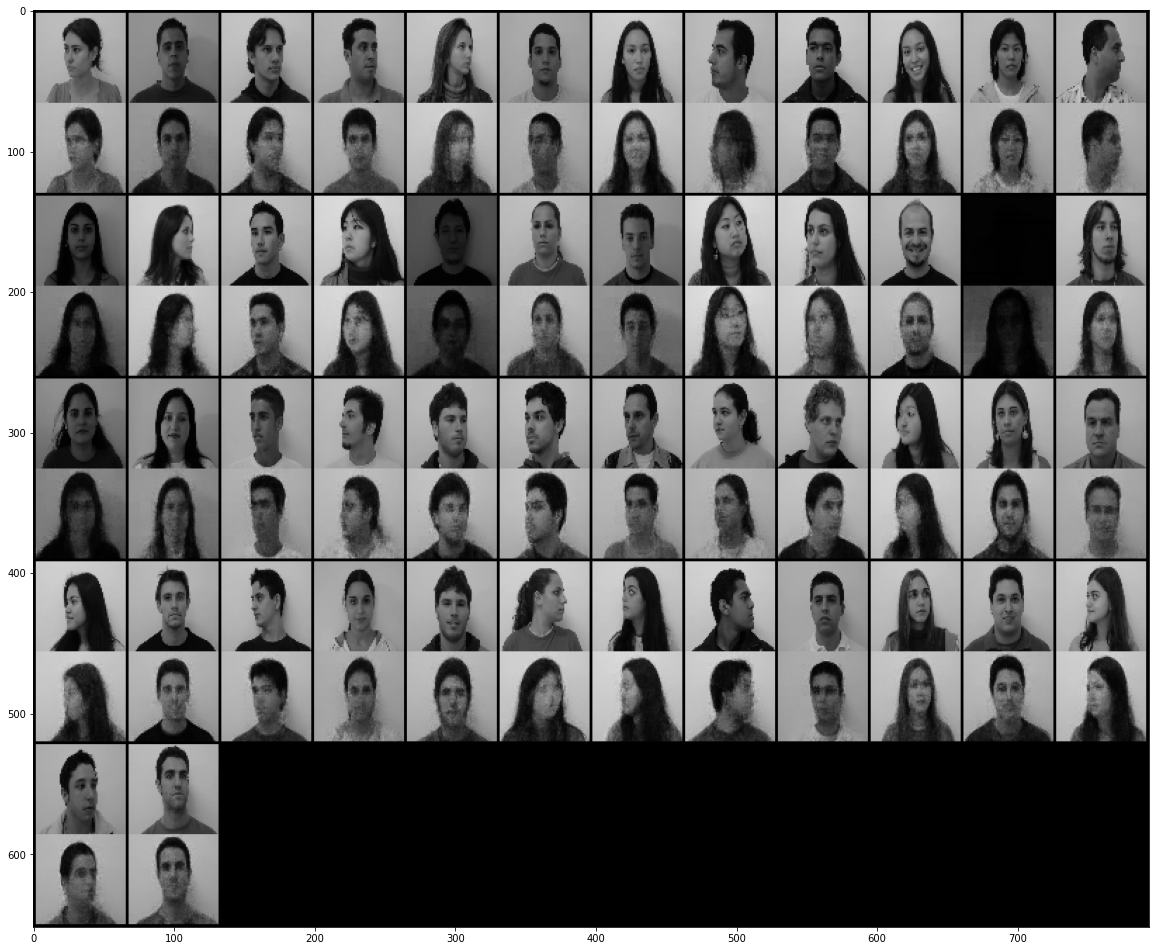

In [31]:
with torch.no_grad():
    for batch in data_module.test_dataloader():
        bz = batch[0].shape[0]
        images, retina = batch
        images_pred = model(retina.cuda()/30)
        im = torch.squeeze(images).cuda()
        mse = F.mse_loss(im, images_pred, reduction="sum")/bz
        print(f"{mse=}")
        break

comparison = torch.cat([images.view(-1,1,64, 64),
               images_pred.view(-1,1,64, 64).cpu()],axis=2).detach()
comparison = torchvision.utils.make_grid(comparison, nrow=12).numpy()
comparison = np.moveaxis(comparison,0,-1)
plt.figure(figsize=(20,20))
plt.imshow(comparison)
plt.savefig("")

In [182]:
def backprop_gradient_mask(model, batch, grad):
    """For one batch, backprop gradient mask.
    
    grad should be H x W"""    
    images, retina = batch
    model.zero_grad()
    batch_size = len(images)
    grad = grad[None].cuda(non_blocking=True).expand(batch_size,-1,-1)
    retina = retina.cuda(non_blocking=True)
    retina.requires_grad=True
    # warning: not general since follows the need to divide by 30 for JohnConv...
    images_pred = model(retina/30)
    # TODO is this what I want?? double check
    torch.autograd.backward(images_pred,grad)
    retina_grad = retina.grad.detach()
    return retina_grad

def batch_backprop_gradient_mask(model, dataloader, grad, progress=False):
    """For all batch, backprop gradient mask.
    
    grad should be H x W"""    
    if progress:
        dataloader = tqdm(dataloader)
    else:
        dataloader = dataloader
    res = []
    for batch in dataloader:
        res.append(backprop_gradient_mask(model, batch, grad))
    return torch.cat(res)

def plot_retina_mask(ret_grad):
    fig,ax = plt.subplots()
    cmax = np.max(np.abs(ret_grad))
    cim = ax.imshow(ret_grad,clim=(-cmax,cmax),cmap="RdBu_r")
    ax.set_title("Coding field")
    plt.colorbar(cim)
    plt.axis('off')
    return fig

## RGCs contributing to single-pixel prediction

### stable over train & test

Text(0.5, 1.0, '(train data) coding field for pixel (16,16)')

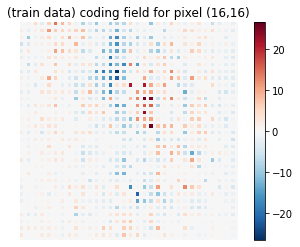

In [139]:
grad = torch.zeros(64,64)
i,j = 16,16
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.train_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"(train data) coding field for pixel ({i},{j})")

Text(0.5, 1.0, '(test data) Coding field for pixel (16,16)')

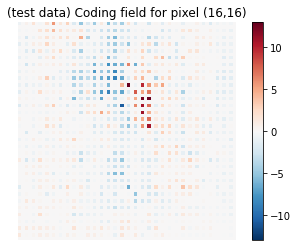

In [140]:
grad = torch.zeros(64,64)
i,j = 16,16
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"(test data) Coding field for pixel ({i},{j})")

### neighboring pixels look similar

Text(0.5, 1.0, 'Coding field for pixel (15,15)')

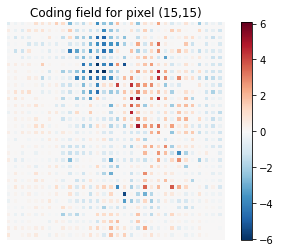

In [141]:
grad = torch.zeros(64,64)
i,j = 15,15
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

Text(0.5, 1.0, 'Coding field for pixel (16,18)')

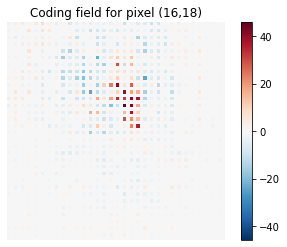

In [153]:
grad = torch.zeros(64,64)
i,j = 16,18
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

### moves around according to pixel to some extent...

Text(0.5, 1.0, 'Coding field for pixel (8,8)')

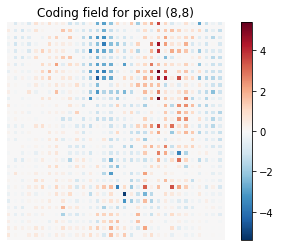

In [143]:
grad = torch.zeros(64,64)
i,j = 8,8
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

Text(0.5, 1.0, 'Coding field for pixel (8,56)')

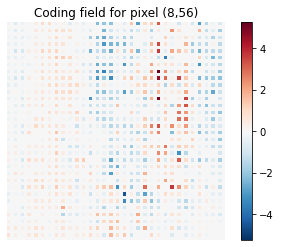

In [145]:
grad = torch.zeros(64,64)
i,j = 8,56
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

Text(0.5, 1.0, 'Coding field for pixel (56,4)')

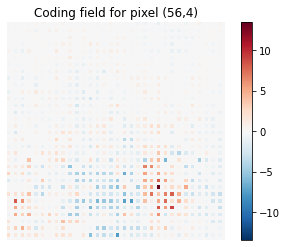

In [148]:
grad = torch.zeros(64,64)
i,j = 56, 4
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

Text(0.5, 1.0, 'Coding field for pixel (56,56)')

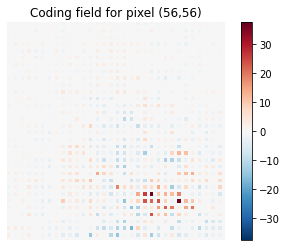

In [147]:
grad = torch.zeros(64,64)
i,j = 56, 56
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

Text(0.5, 1.0, 'Coding field for pixel (32,32)')

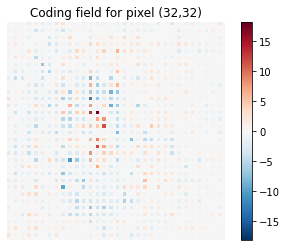

In [149]:
grad = torch.zeros(64,64)
i,j = 32, 32
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

Text(0.5, 1.0, 'Coding field for pixel (32,40)')

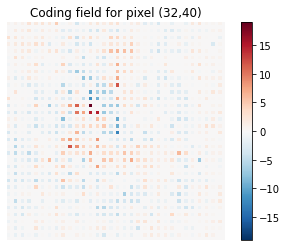

In [150]:
grad = torch.zeros(64,64)
i,j = 32, 40
grad[i,j] = 1
ret_grad = batch_backprop_gradient_mask(model,data_module.test_dataloader(),grad).sum([0,1,2])
fig = plot_retina_mask(ret_grad.numpy())
fig.axes[0].set_title(f"Coding field for pixel ({i},{j})")

### calc Coding Field for all pixels

In [151]:
from itertools import product

In [186]:
# will take a few hours
# pixel_i x pixel_j x retina_h x retina_w
pixel_to_ret_grad = np.zeros([64,64,64,64])
data_module.batch_size = 128
td = data_module.test_dataloader()
grad = torch.zeros(64,64)
for i,j in tqdm(product(range(64),range(64))):
    grad[:] = 0
    grad[i,j] = 1
    pixel_to_ret_grad[i,j] = batch_backprop_gradient_mask(model,td,grad).sum([0,1,2]).cpu().numpy()

4096it [2:26:10,  2.14s/it]


In [214]:
import os
from pathlib import Path

In [238]:
imdir = "/home/tyler/code/dura/glia/interactive/receptive_field/static/"
for i,j in product(range(64), range(64)):
    retpath = os.path.join(imdir, "retina2pixel")
    pixpath = os.path.join(imdir, "pixel2retina")
    Path(retpath).mkdir(exist_ok=True)
    Path(pixpath).mkdir(exist_ok=True)
    if (i % 2 == 0) and (j % 2 == 0):
        # only every other cell is used by model
        im = pixel_to_ret_grad[:,:,i,j]
        cmax = np.max(np.abs(im))
        plt.imsave(retpath+f"/{int(i/2)}_{int(j/2)}.png", im, vmin=-cmax,vmax=cmax,cmap="RdBu_r")
    im = pixel_to_ret_grad[i,j]
    cmax = np.max(np.abs(im))
    plt.imsave(pixpath+f"/{i}_{j}.png", pixel_to_ret_grad[i,j], vmin=-cmax,vmax=cmax,cmap="RdBu_r")

In [216]:
pixel_to_ret_grad.shape

(64, 64, 64, 64)

Text(0.5, 1.0, 'retina2pixel hist')

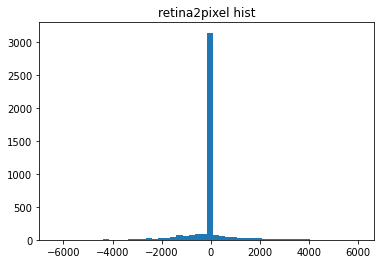

In [219]:
# how many all-zero? (a lot because every other channel isn't used..)
plt.hist(pixel_to_ret_grad.sum((0,1)).reshape(-1),50)
plt.title("retina2pixel hist")

Text(0.5, 1.0, 'pixel2retina hist')

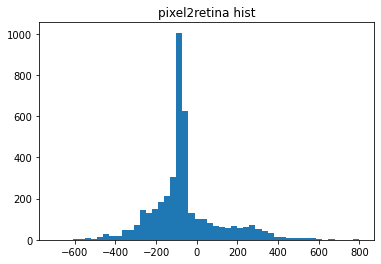

In [221]:
# how many all-zero?
plt.hist(pixel_to_ret_grad.sum((2,3)).reshape(-1),50)
plt.title("pixel2retina hist")

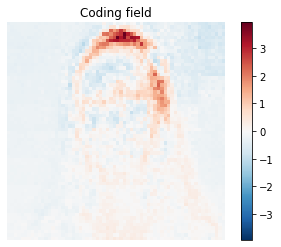

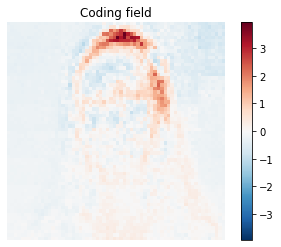

In [204]:
plot_retina_mask(pixel_to_ret_grad[:,:,0,60])

In [188]:
np.save("pixel_to_ret_grad.npy", pixel_to_ret_grad)

In [185]:
import gc
gc.collect()
torch.cuda.empty_cache()

Traceback (most recent call last):
  File "/home/tyler/.conda/envs/torch/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/tyler/.conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/tyler/.conda/envs/torch/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
